In [1]:
import redshift as rs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set_style('dark')

In [3]:
query = """
WITH get_sales AS (
	SELECT
		sale_order_store_date::date,
		EXTRACT(HOUR FROM sale_order_store_date) AS h,
		EXTRACT(year FROM sale_order_store_date) AS y,
		gross_total_value_aft_cnc_bef_ret AS gtv,
		(gross_total_value_aft_cnc_bef_ret <> 0)::int AS p
	FROM business_layer.fact_sales
	WHERE fk_company=1
), calculate_bfd AS (
	SELECT
		*,
		(CASE
		    WHEN y=2011 THEN '2011-11-25'
		    WHEN y=2012 THEN '2012-11-23'
		    WHEN y=2013 THEN '2013-11-29'
		    WHEN y=2014 THEN '2014-11-28'
		    WHEN y=2015 THEN '2015-11-27'
		    WHEN y=2016 THEN '2016-11-25'
		    WHEN y=2017 THEN '2017-11-24'
		    WHEN y=2018 THEN '2018-11-23'
		    WHEN y=2019 THEN '2019-11-29'
		    WHEN y=2020 THEN '2020-11-27'
		    WHEN y=2021 THEN '2021-11-26'
		    WHEN y=2022 THEN '2022-11-25'
		    WHEN y=2023 THEN '2023-11-24'
		    WHEN y=2024 THEN '2024-11-29'
		    WHEN y=2025 THEN '2025-11-28'
		    WHEN y=2026 THEN '2026-11-27'
		    WHEN y=2027 THEN '2027-11-26'
		    WHEN y=2028 THEN '2028-11-24'
		    WHEN y=2029 THEN '2029-11-23'
		    WHEN y=2030 THEN '2030-11-29'
		END)::DATE AS bf_date
	FROM get_sales
)
SELECT y, DATEDIFF(DAY, bf_date, sale_order_store_date) AS d, h, ROUND(SUM(gtv),2) AS gtv, SUM(p) AS p
FROM calculate_bfd
WHERE DATEDIFF(DAY, bf_date, sale_order_store_date) BETWEEN -1 AND 5
GROUP BY y, d, h
"""

In [4]:
filename = rs.get_csv(
    query=query,
    name='blackfriday_validation'
)

2020-11-04 15:23:13.243 | INFO     | redshift:get_credentials:27 - Fetching credentials... 
2020-11-04 15:23:13.246 | INFO     | redshift:get_credentials:38 - Done!
2020-11-04 15:23:13.247 | INFO     | redshift:generate_query_string_with_unload:58 - Generating query...
2020-11-04 15:23:13.248 | INFO     | redshift:generate_query_string_with_unload:78 - Done!
2020-11-04 15:23:13.249 | INFO     | redshift:redshift_execute_query:92 - Starting connection...
2020-11-04 15:23:14.766 | INFO     | redshift:redshift_execute_query:101 - Done!
2020-11-04 15:23:14.767 | INFO     | redshift:redshift_execute_query:102 - Executing query...
2020-11-04 15:23:31.097 | INFO     | redshift:redshift_execute_query:106 - Done!
2020-11-04 15:23:31.098 | INFO     | redshift:download_data_from_s3:151 - Downloading files from s3...
download: s3://gfg-rnd-dev-us-east-1-dump/dafit-br-dump/rnd_redshift_getcsv/blackfriday_validation__1604514193/0000_part_00.gz to TEMP__blackfriday_validation__1604514193/0000_part_00

2020-11-04 15:23:34.490 | INFO     | redshift:redshift_create_header:118 - Fetching columns names and creating output file...
2020-11-04 15:23:40.369 | INFO     | redshift:redshift_create_header:132 - Done!
2020-11-04 15:23:40.369 | INFO     | redshift:convert_to_csv:171 - Converting files...
2020-11-04 15:23:40.380 | INFO     | redshift:convert_to_csv:173 - Done! Created file: /home/ramon_local/gdrive/general/rnd-blackfriday-hourly-forecast/blackfriday_validation.csv
2020-11-04 15:23:40.381 | INFO     | redshift:delete_temp_folder:188 - Deleting folder /home/ramon_local/gdrive/general/rnd-blackfriday-hourly-forecast/TEMP__blackfriday_validation__1604514193/...
2020-11-04 15:23:40.394 | INFO     | redshift:delete_temp_folder:190 - Done!


In [5]:
df = pd.read_csv(filename)

df['x'] = df['d'] + df['h']/24
df['n_gtv'] = df['gtv'] / df.groupby(['y'])['gtv'].transform(np.sum)
df = df.loc[df['y']>=2015]

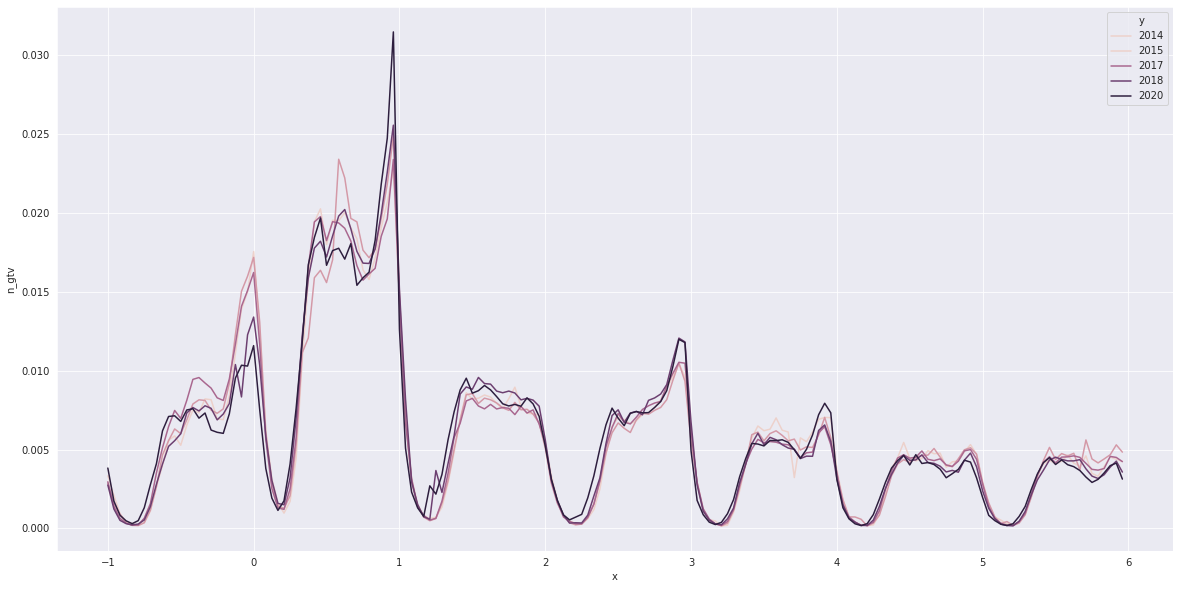

In [6]:
_, ax = plt.subplots(figsize=(20,10))
sns.lineplot(
    x='x',
    y='n_gtv',
    hue='y',
    data=df,
    ax=ax
)
ax.grid()